In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import datetime as dt

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 6)

In [4]:
import sklearn
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

In [5]:
def performance(actual, predicted):
    print('MAE', round(mae(actual, predicted), 3))
    print('RMSE', round(mse(actual, predicted)**0.5, 3))
    print('MAPE', round(mape(actual, predicted), 3))

In [6]:
def adf_test(data, significance_level = 0.05):
    pvalue = sm.tsa.stattools.adfuller(data)[1]
    if pvalue <= significance_level:
        print('Sequence is stationary')
    else:
        print('Sequence is not stationary')

In [7]:
mobile_sales = pd.read_excel('mobilesales.xlsx')

In [8]:
mobile_sales.set_index('DATE',inplace=True)
mobile_sales

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0
...,...
2018-09-01,13838.0
2018-10-01,15351.0
2018-11-01,15615.0


In [9]:
mobile_sales.index.dtype

dtype('<M8[ns]')

In [10]:
mobile_sales.Sales = mobile_sales.Sales.interpolate(method= 'linear')
mobile_sales.Sales

DATE
2001-01-01     6519.0
2001-02-01     6654.0
2001-03-01     7332.0
2001-04-01     7332.0
2001-05-01     8240.0
               ...   
2018-09-01    13838.0
2018-10-01    15351.0
2018-11-01    15615.0
2018-12-01    16941.0
2019-01-01    12160.0
Name: Sales, Length: 217, dtype: float64

## Clipping

In [11]:
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.95), lower=mobile_sales.Sales.quantile(0.05))

In [12]:
train_max_date = mobile_sales.index[-12]
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]]
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]]

## ARIMA Models

In [13]:
train_x

,Sales
DATE,
2001-01-01,7307.8
2001-02-01,7307.8
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0
...,...
2017-09-01,13349.0
2017-10-01,14150.0
2017-11-01,14698.0


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

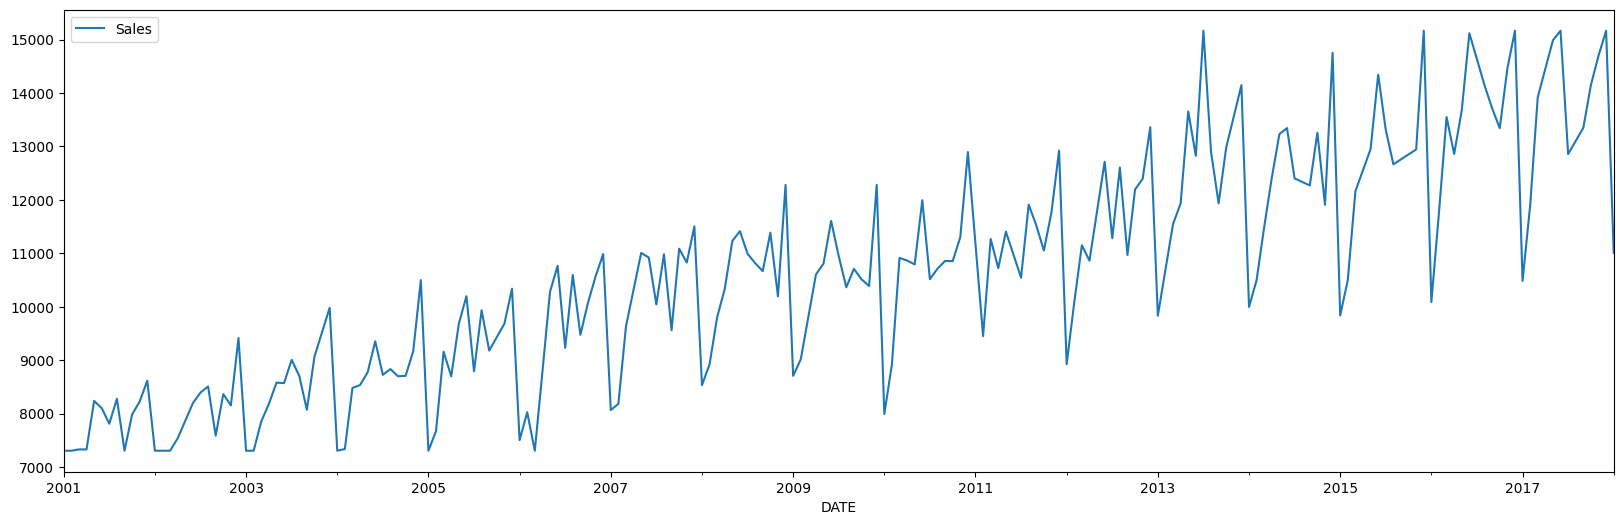

In [15]:
train_x.plot();

In [16]:
adf_test(train_x.Sales)

Sequence is not stationary


In [17]:
train_x_st = train_x.copy()

train_x_st.Sales = train_x_st.Sales.diff(1)
train_x_st.dropna(inplace=True)
adf_test(train_x_st.Sales)

Sequence is stationary


<Axes: xlabel='DATE'>

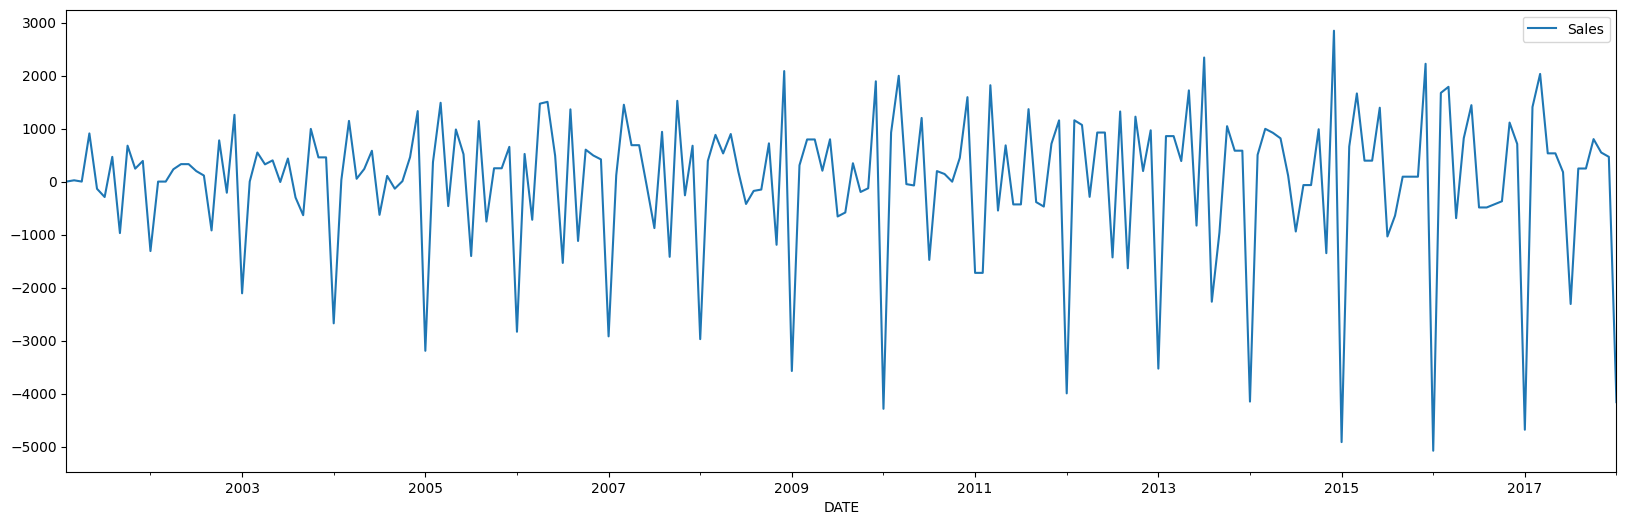

In [18]:
train_x_st.plot()

## AR(10) (Stationary Series Required)

In [19]:
model = SARIMAX(train_x_st.Sales, order=(10,0,0)) #AR(3)
model = model.fit(display=False)
test_x['pred'] = model.forecast(steps=12)

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: display. After release 0.14, this will raise.
  warnings.warn(
C:\Users\ryanr\AppData\Local\Temp\ipykernel_25544\3389058671.py:3: Sett

MAE 1012.768
RMSE 1131.691
MAPE 0.071


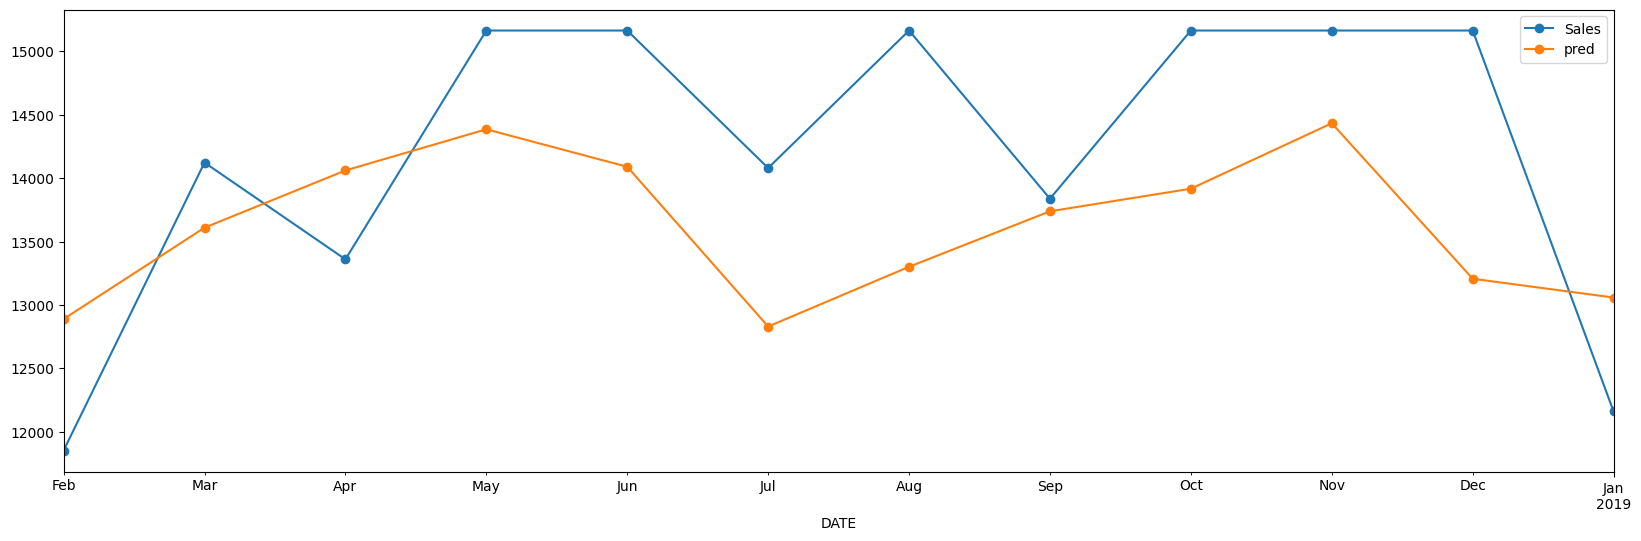

In [20]:
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

## MA(10) (Stationary Series Required)

C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: display. After release 0.14, this will raise.
  warnings.warn(
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-package

MAE 1095.17
RMSE 1369.998
MAPE 0.075


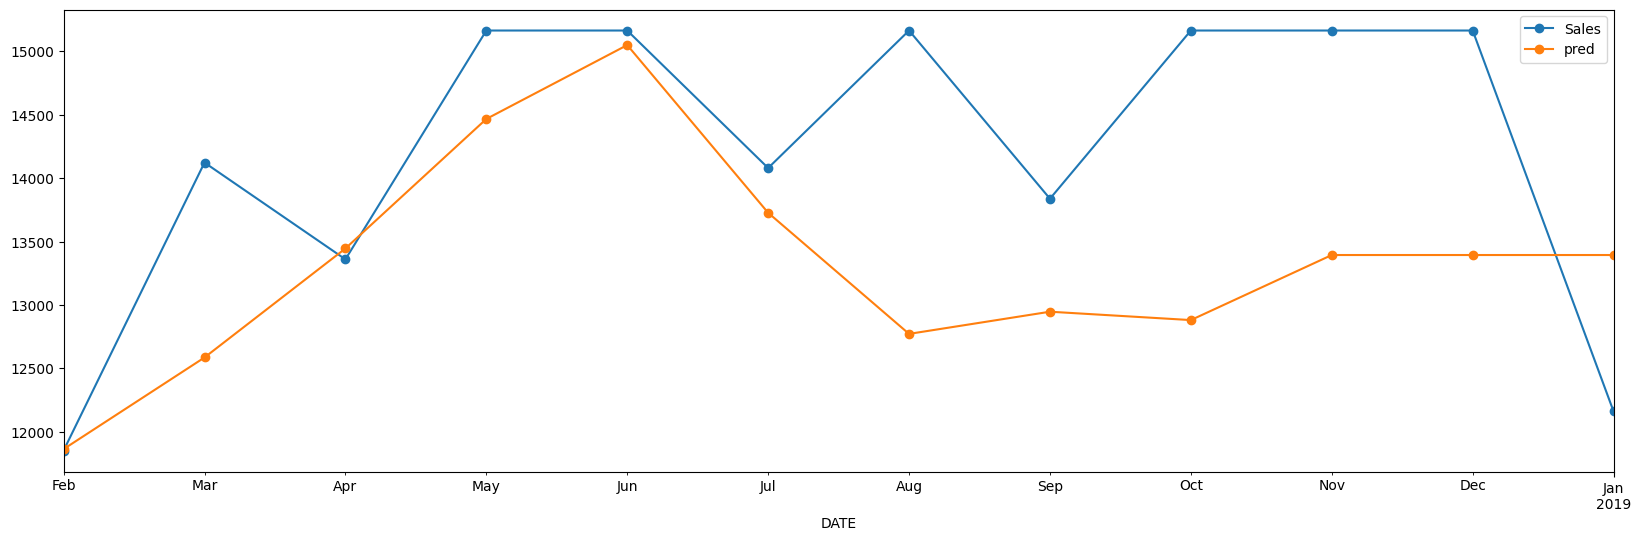

In [21]:
model = SARIMAX(train_x_st.Sales, order=(0,0,10)) #MA(10)
model = model.fit(display=False)
test_x['pred'] = model.forecast(steps=12)

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]



test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

## ARMA(p,q) (Stationary Series Required)

C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA pa

MAE 638.857
RMSE 832.306
MAPE 0.044


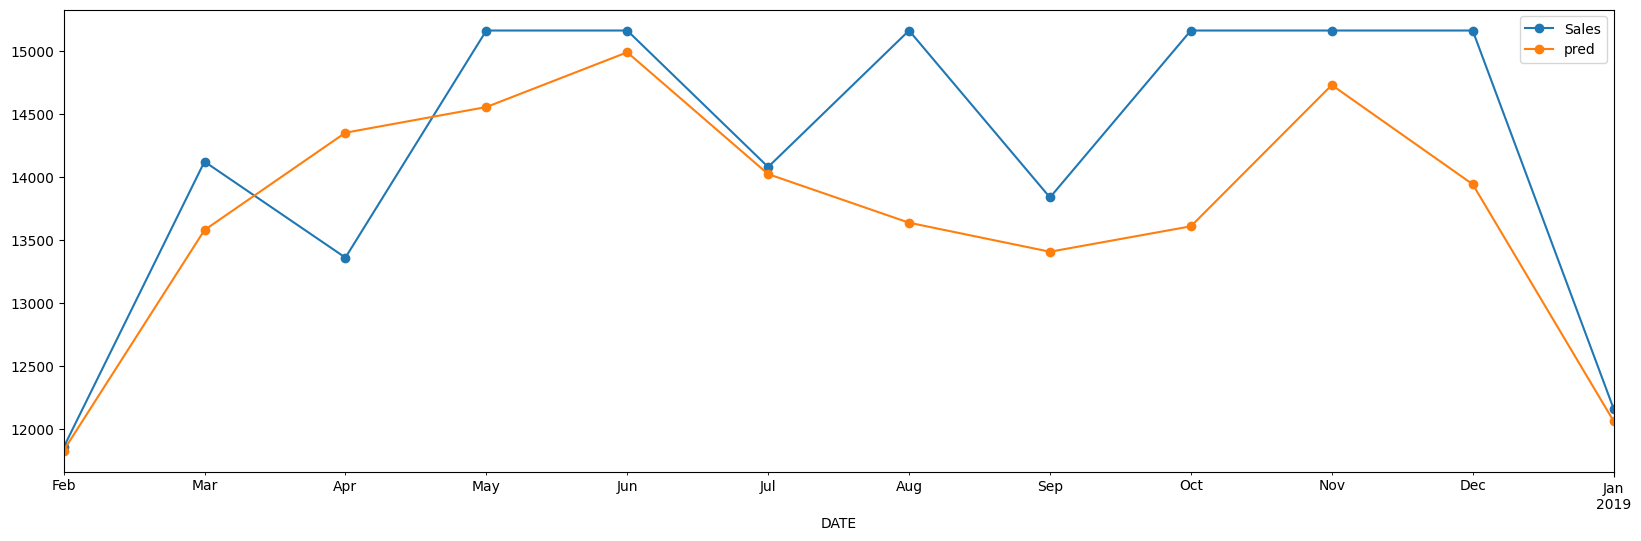

In [22]:
model = SARIMAX(train_x_st.Sales, order=(10,0,5)) #ARMA(10,5)
model = model.fit(display=False)
test_x['pred'] = model.forecast(steps=12)

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]



test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

## ARIMA(p, d, q) (Stationary Series NOT Required) (Mention the # time differencing is needed)

C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: display. After release 0.14, this will raise.
  warnings.warn(
C:\Users\ryanr\AppData\Local\Temp\ipykernel_25544\3249883047.py:3: Sett

MAE 1098.554
RMSE 1198.155
MAPE 0.077


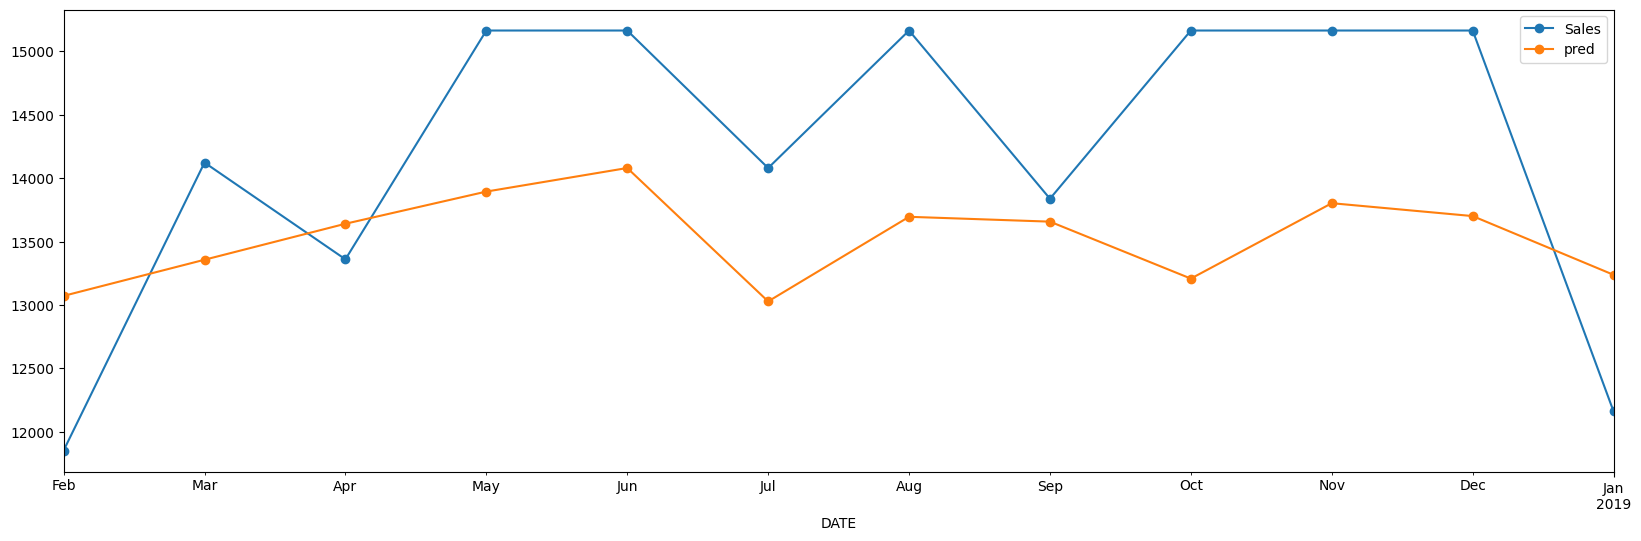

In [23]:
model = SARIMAX(train_x.Sales, order=(5,1,3)) #ARMA(10,5)
model = model.fit(display=False)
test_x['pred'] = model.forecast(steps=12)

#test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1] ## Not required



test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

## SARIMA Model 

C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: display. After release 0.14, this will raise.
  warnings.warn(
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-package

MAE 428.978
RMSE 510.773
MAPE 0.031


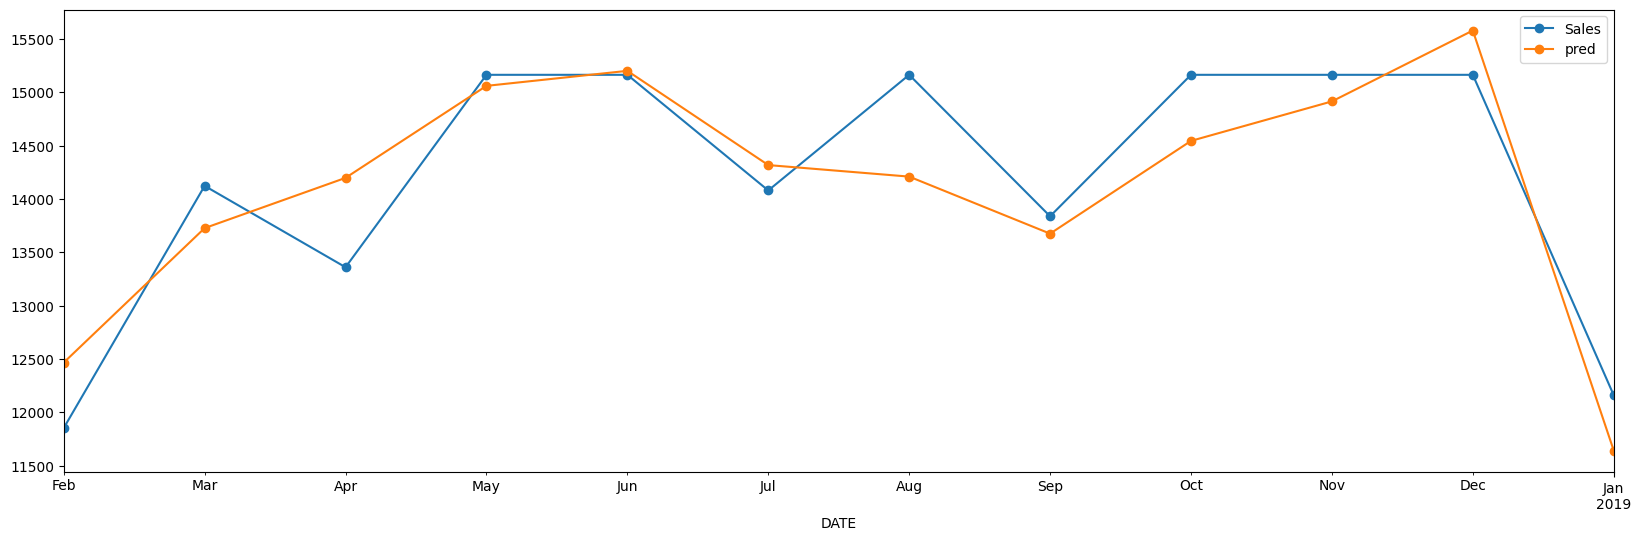

In [24]:
model = SARIMAX(train_x.Sales, order=(5,1,3), seasonal_order=(1,1, 1, 12)) #ARMA(10,5)
model = model.fit(display=False)
test_x['pred'] = model.forecast(steps=12)

#test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1] ## Not required



test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])